In [ ]:
# To get "nature.nhdr", download https://www.youtube.com/watch?v=668nUCeBHyY and run
# `makevideo.jl`
using Pkg
Pkg.precompile()
using Images
using ParameterizedFunctions
eqs = @ode_def begin
    # Lotka-Volterra equations
    d🐭 = α*🐭 - β*🐭*🐱
    d🐱 = δ*🐭*🐱 - γ*🐱
end α β δ γ;
using AxisArrays: AxisArray
using BenchmarkTools
using LoopVectorization
using TestImages
using ImageView
using MappedArrays   # lazy `map`
using IntervalArithmetic
using Plots
rng = -10:0.1:10
holdertable(x::Real, y::Real) = -abs(sin(x)*cos(y)*exp(abs(1 - sqrt(x^2 + y^2)/π)))
holdertable(xy) = holdertable(xy...)    # when passing a vector, tuple, etc.
display(surface(rng, rng, holdertable))
using IntervalOptimisation
mov = load(joinpath("videos", "nature.nhdr"))
imshow(mov)
img = testimage("lighthouse");
img[100:250, 250:500];
imgv = view(img, 100:250, 250:500)


In [ ]:
bitstring(5)

# <center>The Julia programming language</center>
<br>
<center><img src="figures/julia_logo.png" style="height:80px"></center>

### <center>Timothy E. Holy</center>
<center>Department of Neuroscience</center>
<center>Washington University in St. Louis</center>

## Motivation: combining high-level ease with low-level performance

*High level* languages (Python, R, and Matlab) have been growing in popularity because of their efficiency for the programmer.

However, they cannot generally achieve the machine efficiency of *low level* languages (C, C++, Fortran).

The "two language problem":
- test ideas in a high-level language
- when you get frustrated with its performance, rewrite the performance-sensitive parts in a low-level language
- add bindings to call the low-level version from the high-level code


Examples: matrix algebra and array-slicing, sorting algorithms, graph theory, GPU implementations, etc.


## Why is this the "two language *problem*"?

- Most people eventually run up against something they need but which no one has written in a fast language: *it's now up to you*
- You may not be equally comfortable in two languages
- Writing code in a low-level language is generally more laborious
- You often need a lot of "glue code" to call the low-level language from the high-level language

People use lots of tricks to try to circumvent this problem ("vectorize everything"). Sometimes that works very well indeed, but sometimes it leads to torturous code.

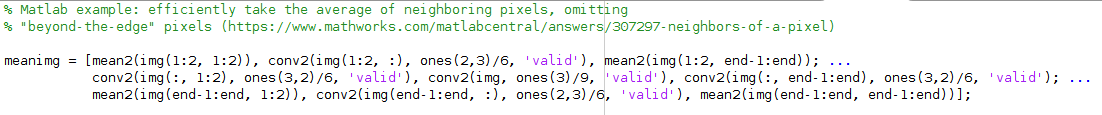

Not only is this hard to read, but but it only works in 2 dimensions: you need to rewrite it for each dimensionality you want to support.

Conversely, it's simple and understandable with `for` loops, and it works for arbitrary dimensions:

In [ ]:
for I in R                                          # for every pixel
    n, s = 0, zero(eltype(out))                     # initialize accumulators
    for J in max(Ifirst, I-I1):min(Ilast, I+I1)     # iterate over neighbors
        s += img[J]                                 # accumulate sum and number of neighbors
        n += 1
    end
    out[I] = s/n                                    # compute the mean
end

## Enter Julia

Started in late 2009 by Jeff Bezanson, Alan Edelman, Stefan Karpinski, and Viral Shah

"Went public" through a now-famous blog post:
<img src="figures/whywecreatedjulia.png" >

## Julia has grown quickly

- 2017: Julia becomes the first language besides Fortran, C, and C++ to break the 1 petaflop barrier
- 2018:
  + Release of Julia v1.0
  + Enters the "top 50 programming languages" lists

- 2020-2023:
  + 45 million cumulative downloads (Jan 2023)
  + Julia ranked mid-20s on "top language" lists, worldwide usage currently estimated to be ~50% of Matlab
  + Dominates the market in certain industries (e.g., pharmokinetics modeling in pharmaceutical industry)
  + JuliaCon goes from ~500 attendees (2019) to >20,000 (2022, virtual)
  + MIT's "Introduction to Computational Thinking" reaches >150k YouTube views within one week for a single lecture
  + more than 1000 contributors to Julia itself, 3-8 new *packages* and 50-60 new *versions* of established packages daily


## Key Julia features (pros and cons)

- new, modern language (con: smaller package ecosystem; pro: elegance)
- aggressive type-specialization and compilation (con: compilation latency; pro: outstanding runtime performance)
- elegant, composable, and reusable code

## Benefits of a modern language: better readability with unicode

Let's define a function to compute cartesian (`x`, `y`, `z`) coordinates from spherical coordinates:

In [ ]:
cartesian(r, θ, ϕ = 0) = r*sin(θ)*cos(ϕ), r*sin(θ)*sin(ϕ), r*cos(θ)  # unicode

In [ ]:
using ParameterizedFunctions

eqs = @ode_def begin
    # Lotka-Volterra equations
    d🐭 = α*🐭 - β*🐭*🐱
    d🐱 = δ*🐭*🐱 - γ*🐱
end α β δ γ;

Mathematical notation can help clarify the meaning of scientific code:

In [ ]:
2 ∈ 4:7       # returns `false`
[1,5] ⊆ 1:5   # returns `true`
# The following are all function definitions
f(x)   = x[1]^2 + x[2]^2
∇f(x)  = [2x[1], 2x[2]]
∇²f(x) = 2*I

# Makie: a plotting package to make you envious...

![image.png](figures/makie1.gif)

![image.png](figures/makie2.gif)

More fun plots: https://twitter.com/MakiePlots

# ...except for the latency

```
julia> plot(data)
```
The first time you do this, ~~wait 35s (on Julia 1.8) for it to compile~~ it takes ~1s (on Julia 1.9).

However package *precompilation* is still slow. Workaround: [Revise.jl](https://github.com/timholy/Revise.jl).

# Julia's outstanding performance

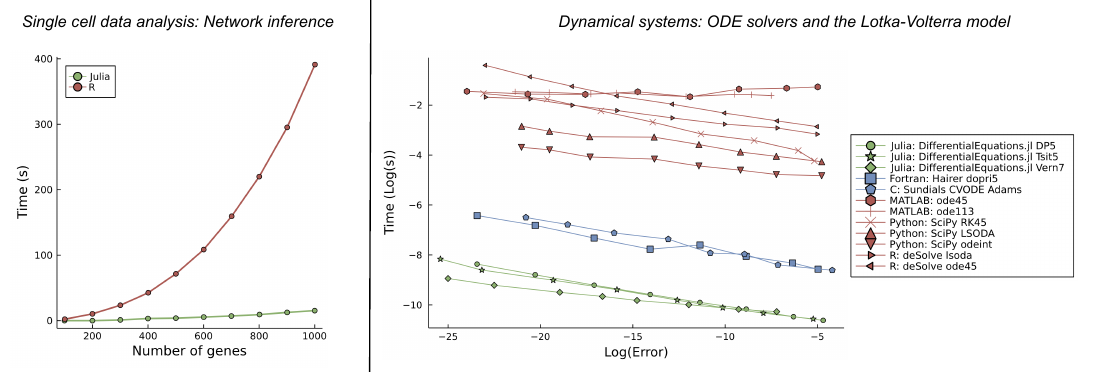

Julia for Biologists (https://arxiv.org/abs/2109.09973)

## Performance in matrix-multiplication

<img src="figures/loopvec_matmul.png">

In [ ]:
using LoopVectorization
function A_mul_B!(𝐂, 𝐀, 𝐁)
    @turbo for m ∈ axes(𝐀,1), n ∈ axes(𝐁,2)
        𝐂ₘₙ = zero(eltype(𝐂))
        for k ∈ axes(𝐀,2)
            𝐂ₘₙ += 𝐀[m,k] * 𝐁[k,n]
        end
        𝐂[m,n] = 𝐂ₘₙ
    end
end

## Where does Julia's speed come from?

Is Julia "fast"? Yes, but even more importantly, Julia *isn't slow*. There's a key distinction:

- slow languages get in the way of the hardware
- not-slow languages remove obstacles

While packages like LoopVectorization make Julia fast by any measure, it implements optimizations that are applicable only in specific circumstances. But Julia is also "not slow" *ubiquitously*.

A simple illustration:

In [ ]:
bitstring(5)

In [ ]:
bitstring(5.0)

Consequence: the rules for arithmetic depend on the *type* of the object.

Implementing `x + y` in a slow language:

In [ ]:
function mysum(x, y)
    if isa(x, Float64) && isa(y, Float64)
        return add64_using_the_fpu(x, y)            # FPU = floating-point unit
    elseif isa(x, Float32) && isa(y, Float32)
        return add32_using_the_fpu(x, y)
    elseif isa(x, Int64) && isa(y, Int64)
        return add64_using_the_integer_unit(x, y)   # integer unit is in the "core CPU"
    elseif isa(x, Int32) && isa(y, Int32)
        return add64_using_the_integer_unit(x, y)
    else
        # convert everything to Float64
        x64, y64 = Float64(x), Float64(y)
        return add64_using_the_fpu(x64, y64)
    end
end

In a not-slow language, the types are known in advance so that the right method can be hard-wired into the compiled code.

Julia doesn't require you to annotate types: it *infers* them from the types of the arguments.

Matlab and Python, sometimes through add-ons, attempt to do the same thing, and when it works you get pretty good performance. But it places a lot of requirements on your code and work only in certain circumstances.

Julia was designed "from the ground up" to allow inference to work well most of the time, not just within a single function but *from the entry point of a computational pipeline to its terminus.*

# Elegance: powerful abstractions and simple code

One of the most impressive Python packages I've encountered is `dask`, which enables *lazy computation* on "big data."

```python
# Python code
import dask.array as da
x = da.random.random((10000, 10000), chunks=(1000, 1000))
# This array syntax doesn't cause computation
y = x + x.T - x.mean(axis=0)      # matlab equivalent: y = x + x' - mean(x, 1)

# Trigger computation by explicitly calling the compute method
y = y.compute()
```

It has a sophisticated system for handling *task graphs*:

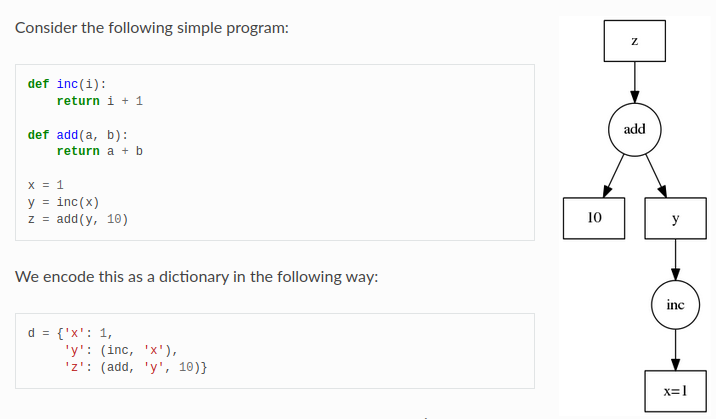

`dask` is big: just `dask.array` is >12,000 lines of "real code" (not including comments & docstrings). The whole package is the effort of many people:

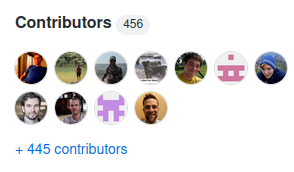

They also get considerable funding from their sponsors:

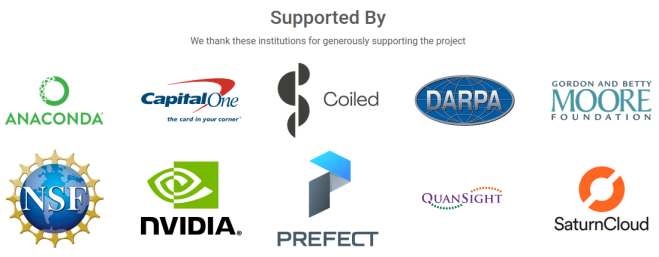

## Outdoing `dask.array` with 20 lines of Julia code

Let's create a lazy array type in Julia:

In [ ]:
# Define a new subtype of `AbstractArray`: `T` is the element type, `N` is the dimensionality
struct OurLazyArray{T,N,F,Axs<:NTuple{N,AbstractUnitRange{Int}}} <: AbstractArray{T,N}
    our_getindex::F     # a function for getting/computing values
    our_axes::Axs       # the set of valid indices of the array (similar to the "shape" or "size")
end

Define two *constructors*:

In [ ]:
# User-supplied element type `T`, other type-parameters are computed from the inputs
OurLazyArray{T}(our_getindex::F, our_axes) where {T,F} =
    OurLazyArray{T, length(our_axes), F, typeof(our_axes)}(our_getindex, our_axes)

In [ ]:
# If the user doesn't manually supply `T`, compute it from `our_getindex`
function OurLazyArray(our_getindex::F, our_axes) where F
    if !isempty(our_axes)   # compute the type from "running" `our_getindex` on the first element
        T = typeof(our_getindex(first.(our_axes)...))
    else                    # or if there isn't a first element, using type-inference
        T = Base._return_type(our_getindex, NTuple{length(our_axes), Int})
    end
    return OurLazyArray{T}(our_getindex, our_axes)
end

Define the essential `AbstractArray` methods:

In [ ]:
# Indexing: call `our_getindex`
Base.@propagate_inbounds function Base.getindex(A::OurLazyArray{T,N}, i::Vararg{Int,N}) where {T,N}
    @boundscheck checkbounds(A, i...)
    convert(T, A.our_getindex(i...))::T
end

In [ ]:
# Two methods regarding the shape/size
# In Julia, `axes` provides support for *arbitrary indexing*: `kernel[-2:2]` might be used with a zero-centered array
Base.size(A::OurLazyArray) = map(length, A.our_axes)
Base.axes(A::OurLazyArray) = A.our_axes

Let's try it out!

In [ ]:
a = ["Hello", "world!"]
our_getindex(i) = reverse(a[i])
la = OurLazyArray(our_getindex, axes(a))

In [ ]:
la[1] = "nope"

## Does this match `dask`'s many other capabilities?

No and yes. The full "cross-node scheduling" capabilities require a package, `Dagger.jl` (>5,000 lines of code)

But Julia is fast enough that often you don't need to use clusters and all the associated pain.

When working on a single machine, you can achieve the remaining capabilities *by composition*:

- arrays bigger than memory: load via `mmap` or other "lazy-loading" package of your choice
- use Julia's native threading (`Threads.@threads`) (generally *much* faster than other forms of CPU parallelism)
- you can use the same tricks on GPUs

## How does this "outdo" `dask`?

- `dask` efficiently supports *element transformation* but not *index transformation*. Implementing a rotation is not feasible except on "chunks" in `dask`.
- `dask` operates "chunkwise" to vectorize performance. This introduces a minimal computational unit; handling chunk edges is tricky.
- `dask` "re-implements" some of `scikit-images`, because the latter eagerly converts all arrays to NumPy array. Boom.

## Composability, lazy operations, and big data

Demo from https://www.youtube.com/watch?v=668nUCeBHyY

In [ ]:
using FileIO
mov = load(joinpath("videos", "nature.nhdr"));
println(summary(mov))

In [ ]:
using ImageView
imshow(mov);

Now let's do some manipulations:

In [ ]:
# Pick a subset of time points
using ImageCore
frames = sort(unique(rand(1:nimages(mov), nimages(mov)÷2)))   # nimages: num of points along :time axis

In [ ]:
movt = view(mov, :, :, frames);                               # this is no longer "strided"
imshow(movt);

In [ ]:
# Drop the red color channel
# MappedArrays is a registered ("official") package very like OurLazyArray
# (We could use that here instead, but see below about a "closure" if you want it to be efficient.)
using MappedArrays
mov_nored = mappedarray(c->RGB(0, c.g, c.b), movt);
imshow(mov_nored);

In [ ]:
# Have some fun: make it spin around

function trot(i, j, t)
    # Define a time-dependent rotation
    θ = t/30
    s, c = sincos(θ)
    Δi, Δj = i - 180, j - 320              # displacement from array center (not hard-coded in a real application)
    Δi1, Δj1 = c*Δi - s*Δj, s*Δi + c*Δj    # perform a spatial rotation
    return round(Int, 180 + Δi1), round(Int, 320 + Δj1), t
end

function trot_closure(img)                 # a "closure" helps type inference (encapsulates `img` within the returned function)
    return function(i, j, t)               # like `our_getindex`
        i, j, t = trot(i, j, t)
        return checkbounds(Bool, img, i, j, t) ? @inbounds(img[i, j, t]) : zero(eltype(img))
    end
end

movr = OurLazyArray(trot_closure(mov_nored), axes(mov_nored));

imshow(movr);

In [ ]:
movr[100,100,10] = RGB(1,0,0)

##### Key takeaways

The same "dumb" video player was able to visualize all of these progressively lazy-modified arrays.
The player doesn't have to understand any of these manipulations: you just combine all these individual pieces, and they all work together without conflict.

We can also pass this array to basically any suitable algorithm and it should Just Work.

In [ ]:
# ... with good performance
@benchmark $movr[100, 100, 10]

# Low-level optimization allows new problem approaches

Many optimization problems have *multiple local minima*. When do we know that we have found the true minimum? The generally accepted answer: *you can't*.

However, it turns out there is an answer: *interval arithmetic*.

In [ ]:
using IntervalArithmetic
.. = IntervalArithmetic.:(..)

x = 2 .. 3

In [ ]:
x^2

In [ ]:
x + x

In [ ]:
x - x

The key idea: if you're optimizing ``f``, and ``f([a,b]) = [c,d]``, you know that ``f`` never achieves a value smaller than `c` over the entire interval `[a,b]`. This lets you *rigorously* exclude whole domains as candidates for finding local minima.

In [ ]:
# Demo using the "Holder table function"
holdertable(x::Real, y::Real) = -abs(sin(x)*cos(y)*exp(abs(1 - sqrt(x^2 + y^2)/π)))
holdertable(xy) = holdertable(xy...)    # when passing a vector, tuple, etc.

In [ ]:
using Plots
rng = -10:0.1:10
surface(rng, rng, holdertable)

In [ ]:
# Many minima. Can we find the best ones?
using IntervalOptimisation
minimise(holdertable, (-10..10) × (-10..10); tol=0.01)

It returns a list of candidates that can't be exluded, based on the tolerance we supplied.

These regions include all 4 equivalent symmetric global minima: [±8.05502, ±9.66459]

## Summary

Julia is still young, and there remain a few rough edges, but it's growing up fast

Attractions include (best of breed?) support for generic programming, world-class performance, and remarkable composability

Other ecosystems have more packages. But sometimes you can accomplish "the impossible" simply by combining packages in creative ways: Julia's composability means packages are just legos waiting to be put together.